In [1]:
pip install d2l

     |████████████████████████████████| 81kB 3.3MB/s 


In [2]:
#from d2l import torch as d2l
import torch
import torchvision
from torch import nn
import warnings
from PIL import Image
from d2l import torch as d2l
from __future__ import print_function
from enum import Enum
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import math
import time
import datetime
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import functools
import torch.nn.functional as F
from operator import itemgetter
from scipy.spatial import distance

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Input Generation

In [4]:
def creating_input(x,y, n = 36):
  input_map = np.zeros((36,36,3))
  #(R_i,G_i,B_i) = HSL_to_RGB(0, True)
  input_map[:,:,0] = 255
  input_map[:,:,1] = 255
  input_map[:,:,2] = 255
  input_map /= 255
  pixel_x = math.floor((x)/0.625 + 55)
  pixel_y = math.floor((y)/0.625 + 73)
  #print(pixel_x,pixel_y)
  (ind_x,ind_y) = conversion_map[pixel_x,pixel_y]
  if (ind_x,ind_y) == (-1,-1):
    print("Out of range, base_map is shown")
    return input_map
  if ind_x < n and ind_y < n:
    ind_x = int(ind_x)
    ind_y = int(ind_y)
    #print(ind_x, ind_y)
    (R,G,B) = HSL_to_RGB(1, False)
    input_map[ind_x,ind_y,0] = R/255
    input_map[ind_x,ind_y,1] = G/255
    input_map[ind_x,ind_y,2] = B/255

  return input_map

In [5]:
def creating_input_with_mask(x,y, n = 36):
  input_map = np.zeros((36,36,3))
  (R_i,G_i,B_i) = HSL_to_RGB(0, True)
  input_map[:,:,0] = R_i
  input_map[:,:,1] = G_i
  input_map[:,:,2] = B_i
  input_map /= 255
  pixel_x = math.floor((x)/0.625 + 55)
  pixel_y = math.floor((y)/0.625 + 73)
  #print(pixel_x,pixel_y)
  (ind_x,ind_y) = conversion_map[pixel_x,pixel_y]
  if (ind_x,ind_y) == (-1,-1):
    print("Out of range")
    mask = "error"
    return input_map, mask
  if ind_x < n and ind_y < n:
    ind_x = int(ind_x)
    ind_y = int(ind_y)
    #print(ind_x, ind_y)
    (R,G,B) = HSL_to_RGB(1, False)
    input_map[ind_x,ind_y,0] = R/255
    input_map[ind_x,ind_y,1] = G/255
    input_map[ind_x,ind_y,2] = B/255

  mask = np.zeros((36,36), dtype=bool)
  mask [ind_x,ind_y] = True
  return input_map, mask

In [6]:
def label_correspond(x,y):
  pixel_x = math.floor((x)/0.625 + 55)
  pixel_y = math.floor((y)/0.625 + 73)
  #print(pixel_x, pixel_y)
  correspond_x = str(float(pixel_x - 55) * 0.625 + 0.3125)
  correspond_y = str(float(pixel_y - 73) * 0.625 + 0.3125)
  label = correspond_x + "_" +   correspond_y + "_2.9.png"
  #print(label)
  return label

#Generator Model Structure

In [7]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        self.in_conv = DoubleConv(input_channels = 4, output_channels = 8)
        self.down_seq_1 = DownSequence(input_channels = 8, output_channels = 16)
        self.down_seq_2 = DownSequence(input_channels = 16, output_channels = 32)
        self.down_seq_3 = DownSequence(input_channels = 32, output_channels = 64)
        self.down_seq_4 = DownSequence(input_channels = 64, output_channels = 128)
        self.down_seq_5 = DownSequence(input_channels = 128, output_channels = 256)
        self.down_seq_6 = DownSequence(input_channels = 256, output_channels = 512)
        self.up_seq_6 = UpSequence(input_channels = 512, output_channels = 256)
        self.up_seq_5 = UpSequence(input_channels = 256, output_channels = 128)
        self.up_seq_4 = UpSequence(input_channels = 128, output_channels = 64)
        self.up_seq_3 = UpSequence(input_channels = 64, output_channels = 32)
        self.up_seq_2 = UpSequence(input_channels = 32, output_channels = 16)
        self.up_seq_1 = UpSequence(input_channels = 16, output_channels = 8)
        self.out_conv = OutConv(input_channels = 8, output_channels = 3)
        
    def forward(self, x):
        x_dc = self.in_conv(x)
        #print('dc: x_dc.shape', x_dc.shape)
        x_d1 = self.down_seq_1(x_dc)
        #print('d1: x_d1.shape', x_d1.shape)
        x_d2 = self.down_seq_2(x_d1)
        #print('d2: x_d2.shape', x_d2.shape)
        x_d3 = self.down_seq_3(x_d2)
        #print('d3: x_d3.shape', x_d3.shape)
        x_d4 = self.down_seq_4(x_d3)
        #print('d4: x_d4.shape', x_d4.shape)
        x_d5 = self.down_seq_5(x_d4)
        #print('d5: x_d5.shape', x_d5.shape)
        x_d6 = self.down_seq_6(x_d5)
        #print('d6: x_d6.shape', x_d6.shape)
        x_u6 = self.up_seq_6(x_d5, x_d6)
        #print('u6: x_u6.shape', x_u6.shape)
        x_u5 = self.up_seq_5(x_d4, x_d5)
        #print('u5: x_u5.shape', x_u5.shape)
        x_u4 = self.up_seq_4(x_d3, x_d4)
        #print('u4: x_u4.shape', x_u4.shape)
        x_u3 = self.up_seq_3(x_d2, x_u4)
        #print('u3: x_u3.shape', x_u3.shape)
        x_u2 = self.up_seq_2(x_d1, x_u3)
        #print('u2: x_u2.shape', x_u2.shape)
        x_u1 = self.up_seq_1(x_dc, x_u2)
        #print('u1: x_u1.shape', x_u1.shape)
        return self.out_conv(x_u1)

class DoubleConv(nn.Module):
    def __init__(self, input_channels, output_channels, mid_channels = None):
        super(DoubleConv, self).__init__()
        if mid_channels == None:
            mid_channels = output_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels = input_channels, 
                      out_channels = mid_channels, 
                      kernel_size = 3,
                      stride = 1, 
                      padding = 1
                      ),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(in_channels = mid_channels, 
                      out_channels = output_channels, 
                      kernel_size = 3, 
                      stride = 1, 
                      padding = 1
                      ),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2,True)
        )

    def forward(self, x):
        #print('at DoubleConv')
        return self.double_conv(x)

class DownSequence(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DownSequence, self).__init__()
        self.down_seq = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride = 2, padding = 1),
            DoubleConv(input_channels, output_channels)
        )

    def forward(self, x):
        #print('at down_seq')
        return self.down_seq(x)

class UpSequence(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UpSequence, self).__init__()
        self.up_seq = nn.ConvTranspose2d(input_channels , 
                                         input_channels // 2, 
                                         kernel_size=2, 
                                         stride = 2,
                                         )
        self.double_conv = DoubleConv(input_channels, 
                                      output_channels)

    def forward(self, x_d, x_u):
        #print('at up_seq')
        x_u = self.up_seq(x_u)
        # selects only size of x_u data from x_d
        diffY = x_d.size()[2] - x_u.size()[2]
        diffX = x_d.size()[3] - x_u.size()[3]
        #print('x_u.shape before cutting', x_u.shape)
        x_u = F.pad(x_u, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        #print('x_u.shape after cutting', x_u.shape)
        
        #print('x_d.shape', x_d.shape)
        return self.double_conv(torch.cat([x_d, x_u], 1))

class OutConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(OutConv, self).__init__()
        self.out_conv = nn.Conv2d(input_channels, 
                                  output_channels, 
                                  kernel_size=1)

    def forward(self, x):
        return self.out_conv(x)

#Parameter Loading and Output Producing

#Decoding

In [8]:
model = UNetGenerator()
model_state = torch.load('/content/drive/MyDrive/ECE496 Capstone/Implementation ----- Code/final_model/test_v6_full_dataset_g_lr_0.000655_d_lr_0.0004_G_ne6000_niter102000_e2751_iter46767')
model.load_state_dict(state_dict=model_state)
is_use_cuda = True
if is_use_cuda and torch.cuda.is_available():
    model.cuda()

## Colour Value Loading

In [9]:
header = ['id(row)', 'id(col)','X[m]',	'Y[m]',	'Z[m]']
map = pd.read_csv(
      "/content/drive/MyDrive/ECE496 Capstone/data/coordinate determination/Please Follow This.csv",
      names=header,
      index_col=False)
map = map[1:]
map_np=np.array(map)
map_reference = np.array(map)
map_np = map_np.astype(np.float)
map_np_limited = map_np[:1296,:4]
map_np_limited[:,2] -= 0.3125
map_np_limited[:,2] /= 0.625
map_np_limited[:,3] -= 0.3125
map_np_limited[:,3] /= 0.625
map_np_limited[:,2] += 55
map_np_limited[:,3] += 73
#print(map_np_limited)

adjusted_max_val = 124.03628501370073

conversion_map = np.zeros((128,128,2))
conversion_map -= 1
for entries in map_np_limited:
  (x,y) = (int(entries[2]),int(entries[3]))
  conversion_map[x,y,0] = int(entries[0])
  conversion_map[x,y,1] = int(entries[1])

conversion_map_reverse = np.zeros((36,36,2))
for entries in map_np_limited:
  (x,y) = (int(entries[0]),int(entries[1]))
  conversion_map_reverse[x,y,0] = int(entries[2])
  conversion_map_reverse[x,y,1] = int(entries[3])

#print(conversion_map)
#print(conversion_map_reverse)

## RGB to HSL to Power dB

In [10]:
def HSL_to_RGB(scaled, out_range_indicator):
  hue = ((scaled)**3) * 240
  #hue = 120.536
  #print(hue)
  if out_range_indicator == True:
    saturation = 0.35
    luminance = 0.35
  else:
    saturation = 1
    luminance = 0.6
  c = (1 - abs(2 * luminance - 1)) * saturation
  x = c * (1 - abs((hue / 60) % 2 - 1))
  m = luminance - c/ 2
  r_ = 0
  g_ = 0
  b_ = 0
  if hue < 60:
    (r_, g_, b_) = (c,x,0)
  elif hue < 120:
    (r_, g_, b_) = (x,c,0)
  elif hue < 180:
    (r_, g_, b_) = (0,c,x)
  elif hue < 240:
    (r_, g_, b_) = (0,x,c)
  elif hue < 300:
    (r_, g_, b_) = (x,0,c)
  else:
    (r_, g_, b_) = (c,0,x)
  R = ((r_ + m) * 255)
  G = ((g_ + m) * 255)
  B = ((b_ + m) * 255)
  return (R,G,B)

In [11]:
def RGB_to_HSL_to_Power_dB(R_, G_, B_):
  c_max = max(R_, G_, B_)
  c_min = min(R_, G_, B_)
  delta = c_max - c_min
  
  Hue = 0
  if delta == 0:
    Hue = 0
  elif c_max == R_:
    Hue = 60 * (((G_ - B_)/delta) % 6)
  elif c_max == G_:
    Hue = 60 * ((B_ - R_)/delta + 2)
  elif c_max == B_:
    Hue = 60 * ((R_ - G_)/delta + 4)
  #print(Hue)
  if Hue > 240 and Hue <= 300:
    Hue = 240
  elif Hue > 300:
    Hue = 0

  scaled_factor = (Hue / 240) ** (1/3)
  
  power = scaled_factor * 250 - 250
  #print(power)
  if power <= -200:
    power = -300
  return power 
  

In [12]:
def input_with_mask_channel(mask, input_image):
    """
    Returns 4 channel image with binary mask as 4th channel
    mask - binary mask (tensor)
    image - tensor of image (tensor)
    """

    # Stack mask as 4th channel
    input_image_with_mask = torch.from_numpy(np.dstack((input_image,mask)))
    input_image_with_mask = input_image_with_mask.permute(2,0,1)
    if list(input_image_with_mask.shape) != [4, 36, 36]:
      print(input_image_with_mask.shape)
    input_image_with_mask = np.array(input_image_with_mask)
    # Output - 4 x 36 x 36
    return input_image_with_mask

In [13]:
def get_physical_coordinates(name):
    return [float(s) for s in name.strip('.png').split("_")]

# Decoding Actual

In [14]:
def label_output_power(x,y):
  label = label_correspond(x,y)
  coordinates = get_physical_coordinates(label)
  input_image, mask = creating_input_with_mask(coordinates[0],coordinates[1])
  if mask == "error":
    print("out of physical range, try again")
    return np.zeros((1296, 3)), np.zeros((1296, 3))

  input_image_masked = input_with_mask_channel(mask, input_image)
  input_image_tensor = torch.from_numpy(input_image_masked)
  input_image_tensor = torch.unsqueeze(input_image_tensor, dim=0)
  output = model(input_image_tensor)
  output = (output * 127.5) + 127.5
  output_np = np.transpose(output[0].detach().cpu()/255,(1, 2, 0))

  plt.imshow(output_np)
  #print(output_np.size())

  x_128 = int((coordinates[0]-0.3125)/0.625+55)
  y_128 = int((coordinates[1]-0.3125)/0.625+73)
  #print(x_128, y_128)
  x_36 = conversion_map[x_128, y_128, 0]
  y_36 = conversion_map[x_128, y_128, 1]
  #print(x_36, y_36)
  output_conversion = map_np_limited

  #Rank each pixel id by the euclidean distance between it and the WAP pixel id
  dictionary_36 = {}
  for x_index in range(36):
    for y_index in range(36):
      if x_index == x_36 and y_index == y_36:
        continue
      pixel_distance = ((x_index - x_36)**2 + (y_index - y_36)**2)**0.5
      dictionary_36[(x_index, y_index)] = pixel_distance
    
  #print(dictionary_36)
  #print(len(dictionary_36))
  #print(output_np.shape)
  image_pos_colour_power=np.zeros((1296, 7))

  for x_index in range(36):
    for y_index in range(36):
      if x_index == x_36 and y_index == y_36:
        continue
      index_ = y_index + x_index * 36
      image_pos_colour_power[index_,0] = x_index
      image_pos_colour_power[index_,1] = y_index
      R_ = output_np[x_index, y_index, 0]
      G_ = output_np[x_index, y_index, 1]
      B_ = output_np[x_index, y_index, 2]
      image_pos_colour_power[index_,2] = R_
      image_pos_colour_power[index_,3] = G_
      image_pos_colour_power[index_,4] = B_
      image_pos_colour_power[index_,5] = RGB_to_HSL_to_Power_dB(R_, G_, B_)
      image_pos_colour_power[index_,6] = dictionary_36[(x_index, y_index)]
      #print(image_pos_colour_power[index_])
  #print("image_pos_colour_power")
  #print(image_pos_colour_power)
  
  #index = 16 + 12 * 36
  #print(image_pos_colour_power[index])
  #print(max(image_pos_colour_power[:,5]))

  F_value_frontier = []

  for item in image_pos_colour_power:
    power = item[5]
    normalized_power = (power + 300)/300
    distance = item[6]
    normalized_distance = distance /(36*(2**0.5))
    F_value = normalized_power - normalized_distance
    F_value_frontier.append([power, F_value])

  F_value_frontier = sorted(F_value_frontier, key = itemgetter(1), reverse=True)

  distance_frontier = []
  list_128 = np.zeros((1296, 3))
  list_128[:,0:2] = map_np_limited[:,2:]
  for entries in list_128:
    entries[2] = (((entries[0] - x_128)**2 + (entries[1] - y_128)**2)**0.5)/adjusted_max_val
  #print(list_128)

  reference_distance_list = list_128.tolist()
  reference_distance_list = sorted(reference_distance_list, key=itemgetter(2))
  del reference_distance_list[0]
  #print(np.array(reference_distance_list))

  final_frontier = []
 
  for index_ in range(1295): 
    x = reference_distance_list[index_][0]
    y = reference_distance_list[index_][1]
    power = F_value_frontier[index_][0]
    final_frontier.append([x,y,power])
  
  final_frontier.append([x_128, y_128, 0])
  #print(len(final_frontier))
  #print(unable_match)

  decoded_output = np.array(final_frontier)
  decoded_output_physical = decoded_output.copy()
  decoded_output_physical[:, 0] -= 55
  decoded_output_physical[:, 0] *= 0.625
  decoded_output_physical[:, 0] += 0.3125
  decoded_output_physical[:, 1] -= 73
  decoded_output_physical[:, 1] *= 0.625
  decoded_output_physical[:, 1] += 0.3125

  return decoded_output, decoded_output_physical
  

0.9375_-9.6875_2.9.png


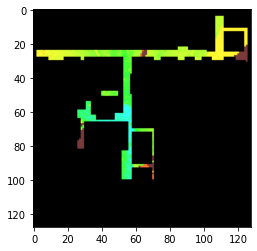

In [15]:
label = label_correspond(1,-10)
print(label)
image_test = plt.imread('/content/drive/MyDrive/ECE496 Capstone/data/png_128/0.9375_-9.6875_2.9.png')
plt.imshow(image_test)

0.9375_-9.6875_2.9.png


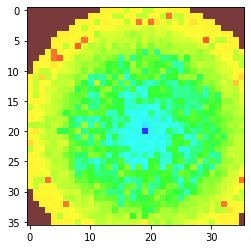

In [16]:
image_path = '/content/drive/MyDrive/ECE496 Capstone/data/1296 dataset (no duplicate)/image_new_encode/'
label = label_correspond(1,-10)
print(label)
image = plt.imread('/content/drive/MyDrive/ECE496 Capstone/testing.png')
plt.imshow(image)

# DEMO

## Demo Helper Functions

In [17]:
def encode_WAP(x,y):
  label = label_correspond(x,y)
  coordinates = get_physical_coordinates(label)
  print("Corresponding Physical Label is", coordinates)
  demo_input = creating_input(coordinates[0],coordinates[1])
  input_image, mask = creating_input_with_mask(coordinates[0],coordinates[1])
  if mask == "error":
    print("out of physical range, try again")
    return np.zeros((36,36,4))
  plt.imshow(demo_input)
  input_image_masked = input_with_mask_channel(mask, input_image)
  input_image_tensor = torch.from_numpy(input_image_masked)
  input_image_tensor = input_image_tensor.float()
  input_image_tensor = torch.unsqueeze(input_image_tensor, dim=0)
  
  return input_image_tensor

In [18]:
def generate_output(input_image_tensor):
  if input_image_tensor == np.zeros((36,36,4)):
    print("no encoded input provided")
    return np.zeros((36,36,3))
  input_image_tensor = input_image_tensor.cuda()
  output = model(input_image_tensor)
  output = (output * 127.5) + 127.5
  output_np = np.transpose(output[0].detach().cpu()/255,(1, 2, 0))
  plt.imshow(output_np)
  return output_np

In [19]:
def decode_output(x, y, output_np):
  label = label_correspond(x,y)
  coordinates = get_physical_coordinates(label)
  if output_np == np.zeros((36,36,3)):
    print("no output provided")
    return np.zeros((1296, 3)), np.zeros((1296, 3))
  x_128 = int((coordinates[0]-0.3125)/0.625+55)
  y_128 = int((coordinates[1]-0.3125)/0.625+73)
  x_36 = conversion_map[x_128, y_128, 0]
  y_36 = conversion_map[x_128, y_128, 1]
  output_conversion = map_np_limited

  #Rank each pixel id by the euclidean distance between it and the WAP pixel id
  dictionary_36 = {}
  for x_index in range(36):
    for y_index in range(36):
      if x_index == x_36 and y_index == y_36:
        continue
      pixel_distance = ((x_index - x_36)**2 + (y_index - y_36)**2)**0.5
      dictionary_36[(x_index, y_index)] = pixel_distance
    
  image_pos_colour_power=np.zeros((1296, 7))

  for x_index in range(36):
    for y_index in range(36):
      if x_index == x_36 and y_index == y_36:
        continue
      index_ = y_index + x_index * 36
      image_pos_colour_power[index_,0] = x_index
      image_pos_colour_power[index_,1] = y_index
      R_ = output_np[x_index, y_index, 0]
      G_ = output_np[x_index, y_index, 1]
      B_ = output_np[x_index, y_index, 2]
      image_pos_colour_power[index_,2] = R_
      image_pos_colour_power[index_,3] = G_
      image_pos_colour_power[index_,4] = B_
      image_pos_colour_power[index_,5] = RGB_to_HSL_to_Power_dB(R_, G_, B_)
      image_pos_colour_power[index_,6] = dictionary_36[(x_index, y_index)]

  F_value_frontier = []

  for item in image_pos_colour_power:
    power = item[5]
    normalized_power = (power + 300)/300
    distance = item[6]
    normalized_distance = distance /(36*(2**0.5))
    F_value = normalized_power - normalized_distance
    F_value_frontier.append([power, F_value])

  F_value_frontier = sorted(F_value_frontier, key = itemgetter(1), reverse=True)

  distance_frontier = []
  list_128 = np.zeros((1296, 3))
  list_128[:,0:2] = map_np_limited[:,2:]
  for entries in list_128:
    entries[2] = (((entries[0] - x_128)**2 + (entries[1] - y_128)**2)**0.5)/adjusted_max_val

  reference_distance_list = list_128.tolist()
  reference_distance_list = sorted(reference_distance_list, key=itemgetter(2))
  del reference_distance_list[0]

  final_frontier = []
 
  for index_ in range(1295): 
    x = reference_distance_list[index_][0]
    y = reference_distance_list[index_][1]
    power = F_value_frontier[index_][0]
    final_frontier.append([x,y,power])
  
  final_frontier.append([x_128, y_128, 0])

  decoded_output = np.array(final_frontier)
  decoded_output_physical = decoded_output.copy()
  decoded_output_physical[:, 0] -= 55
  decoded_output_physical[:, 0] *= 0.625
  decoded_output_physical[:, 0] += 0.3125
  decoded_output_physical[:, 1] -= 73
  decoded_output_physical[:, 1] *= 0.625
  decoded_output_physical[:, 1] += 0.3125
  np.savetxt("/content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_{}_{}.csv".format(coordinates[0], coordinates[1]), decoded_output_physical, delimiter=',',fmt = '%.4f')
  print("Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_{}_{}.csv".format(coordinates[0], coordinates[1]))
  return decoded_output, decoded_output_physical

In [20]:
def output_powermap(decoded_output):
  final_image = np.zeros((128, 128, 3))
  for entries in decoded_output:
    (x,y) = (int(entries[0]), int(entries[1]))
    if entries[2] <= -250:
      out_range_indicator = True
      scaled = 0
    else: 
      out_range_indicator = False
      scaled = (entries[2] + 250)/(250)
    (R,G,B) = HSL_to_RGB(scaled, out_range_indicator)
    final_image[x,y,0] = R/255
    final_image[x,y,1] = G/255
    final_image[x,y,2] = B/255

  plt.imshow(final_image)
  return final_image

In [21]:
def output_powermap_no_plot(decoded_output):
  final_image = np.zeros((128, 128, 3))
  for entries in decoded_output:
    (x,y) = (int(entries[0]), int(entries[1]))
    if entries[2] <= -250:
      out_range_indicator = True
      scaled = 0
    else: 
      out_range_indicator = False
      scaled = (entries[2] + 250)/(250)
    (R,G,B) = HSL_to_RGB(scaled, out_range_indicator)
    final_image[x,y,0] = R/255
    final_image[x,y,1] = G/255
    final_image[x,y,2] = B/255

  return final_image

In [22]:
def label_output_power(x,y):
  label = label_correspond(x,y)
  coordinates = get_physical_coordinates(label)
  demo_input = creating_input(coordinates[0],coordinates[1])
  input_image, mask = creating_input_with_mask(coordinates[0],coordinates[1])
  if mask == "error":
    print("out of physical range, try again")
    return np.zeros((1296, 3)), np.zeros((1296, 3))

  input_image_masked = input_with_mask_channel(mask, input_image)
  input_image_tensor = torch.from_numpy(input_image_masked)
  input_image_tensor = input_image_tensor.float()
  input_image_tensor = torch.unsqueeze(input_image_tensor, dim=0)
  input_image_tensor = input_image_tensor.cuda()
  output = model(input_image_tensor)
  output = (output * 127.5) + 127.5
  output_np = np.transpose(output[0].detach().cpu()/255,(1, 2, 0))

  x_128 = int((coordinates[0]-0.3125)/0.625+55)
  y_128 = int((coordinates[1]-0.3125)/0.625+73)
  print("corresponding 128-scale coordinate", x_128, y_128)
  x_36 = conversion_map[x_128, y_128, 0]
  y_36 = conversion_map[x_128, y_128, 1]
  print("corresponding pixel coordinate", x_36, y_36)
  output_conversion = map_np_limited

  #Rank each pixel id by the euclidean distance between it and the WAP pixel id
  dictionary_36 = {}
  for x_index in range(36):
    for y_index in range(36):
      if x_index == x_36 and y_index == y_36:
        continue
      pixel_distance = ((x_index - x_36)**2 + (y_index - y_36)**2)**0.5
      dictionary_36[(x_index, y_index)] = pixel_distance
    
  image_pos_colour_power=np.zeros((1296, 7))

  for x_index in range(36):
    for y_index in range(36):
      if x_index == x_36 and y_index == y_36:
        continue
      index_ = y_index + x_index * 36
      image_pos_colour_power[index_,0] = x_index
      image_pos_colour_power[index_,1] = y_index
      R_ = output_np[x_index, y_index, 0]
      G_ = output_np[x_index, y_index, 1]
      B_ = output_np[x_index, y_index, 2]
      image_pos_colour_power[index_,2] = R_
      image_pos_colour_power[index_,3] = G_
      image_pos_colour_power[index_,4] = B_
      image_pos_colour_power[index_,5] = RGB_to_HSL_to_Power_dB(R_, G_, B_)
      image_pos_colour_power[index_,6] = dictionary_36[(x_index, y_index)]

  F_value_frontier = []

  for item in image_pos_colour_power:
    power = item[5]
    normalized_power = (power + 300)/300
    distance = item[6]
    normalized_distance = distance /(36*(2**0.5))
    F_value = normalized_power - normalized_distance
    F_value_frontier.append([power, F_value])

  F_value_frontier = sorted(F_value_frontier, key = itemgetter(1), reverse=True)

  distance_frontier = []
  list_128 = np.zeros((1296, 3))
  list_128[:,0:2] = map_np_limited[:,2:]
  for entries in list_128:
    entries[2] = (((entries[0] - x_128)**2 + (entries[1] - y_128)**2)**0.5)/adjusted_max_val

  reference_distance_list = list_128.tolist()
  reference_distance_list = sorted(reference_distance_list, key=itemgetter(2))
  del reference_distance_list[0]

  final_frontier = []
 
  for index_ in range(1295): 
    x = reference_distance_list[index_][0]
    y = reference_distance_list[index_][1]
    power = F_value_frontier[index_][0]
    final_frontier.append([x,y,power])
  
  final_frontier.append([x_128, y_128, 0])

  decoded_output = np.array(final_frontier)
  decoded_output_physical = decoded_output.copy()
  decoded_output_physical[:, 0] -= 55
  decoded_output_physical[:, 0] *= 0.625
  decoded_output_physical[:, 0] += 0.3125
  decoded_output_physical[:, 1] -= 73
  decoded_output_physical[:, 1] *= 0.625
  decoded_output_physical[:, 1] += 0.3125
  np.savetxt("/content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_{}_{}.csv".format(coordinates[0], coordinates[1]), decoded_output_physical, delimiter=',',fmt = '%.4f')
  print("Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_{}_{}.csv".format(coordinates[0], coordinates[1]))
  
  #print(label)
  ground_truth_directory = '/content/drive/MyDrive/ECE496 Capstone/data/1296 dataset (no duplicate)/image_new_encode/'
  ground_truth_image = plt.imread(ground_truth_directory + label)
  final_power_map = output_powermap_no_plot(decoded_output)
  
  fig = plt.figure(figsize=(20, 20))
  fig.add_subplot(1,4,1)
  plt.imshow(demo_input)
  plt.title("Encoded Input") 
  fig.add_subplot(1,4,2)
  plt.imshow(output_np)
  plt.title("Generated Output")
  fig.add_subplot(1,4,3)
  plt.imshow(ground_truth_image)
  plt.title("Ground Truth Image")  
  fig.add_subplot(1,4,4)
  plt.imshow(final_power_map)
  plt.title("Decoded Power Map")

  return decoded_output, decoded_output_physical

## Miscellaneous

In [23]:
def creating_input_with_mask_v2(x,y):
  input_map = np.zeros((36,36,3))
  (R_i,G_i,B_i) = HSL_to_RGB(0, True)
  input_map[:,:,0] = R_i
  input_map[:,:,1] = G_i
  input_map[:,:,2] = B_i
  input_map /= 255

  (R,G,B) = HSL_to_RGB(1, False)
  input_map[x,y,0] = R/255
  input_map[x,y,1] = G/255
  input_map[x,y,2] = B/255

  mask = np.zeros((36,36), dtype=bool)
  mask [x,y] = True
  return input_map, mask

In [24]:
for x in range(36):
  for y in range(36):
    input_image, mask = creating_input_with_mask_v2(x,y)
    input_image_masked = input_with_mask_channel(mask, input_image)
    input_image_tensor = torch.from_numpy(input_image_masked)
    input_image_tensor = input_image_tensor.float()
    input_image_tensor = torch.unsqueeze(input_image_tensor, dim=0)
    input_image_tensor = input_image_tensor.cuda()
    output = model(input_image_tensor)
    output = (output * 127.5) + 127.5
    output_np = np.transpose(output[0].detach().cpu()/255,(1, 2, 0))
    print("pixel coordinate", x, y)
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1,2,1)
    plt.imshow(input_image)
    plt.title("Encoded Input") 
    fig.add_subplot(1,2,2)
    plt.imshow(output_np)
    plt.title("Generated Output")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Demo Step by Step

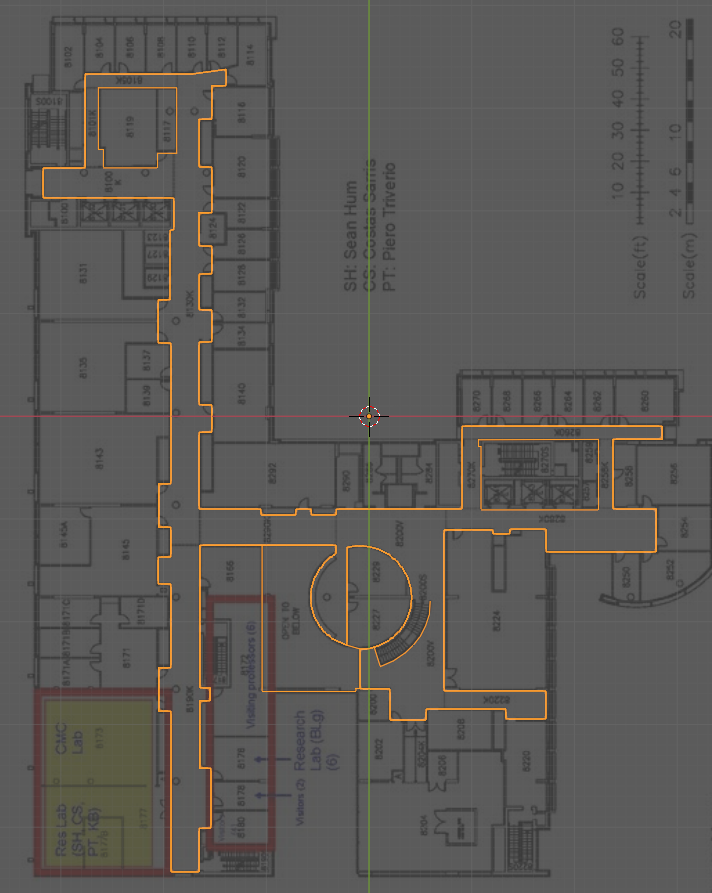

In [23]:
model = UNetGenerator()
model_state = torch.load('/content/drive/MyDrive/ECE496 Capstone/Implementation ----- Code/final_model/test_v6_full_dataset_g_lr_0.000655_d_lr_0.0004_G_ne6000_niter102000_e2751_iter46767')
model.load_state_dict(state_dict=model_state)
is_use_cuda = True
if is_use_cuda and torch.cuda.is_available():
    model.cuda()

Corresponding Physical Label is [22.8125, -8.4375, 2.9]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


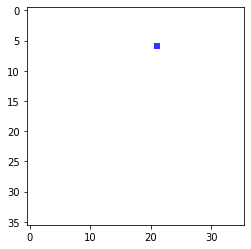

In [24]:
input_image_tensor = encode_WAP(22.8, -8.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


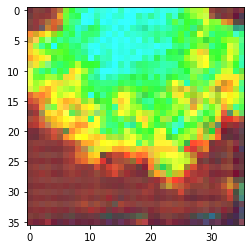

In [25]:
output_np = generate_output(input_image_tensor)

In [26]:
(decoded_output, decoded_output_physical) = decode_output(22.8, -8.5, output_np)

Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_22.8125_-8.4375.csv


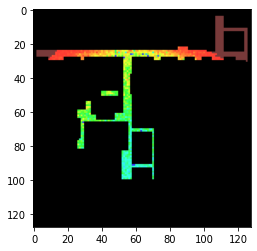

In [27]:
final_power_map = output_powermap(decoded_output)

## Demo One Input

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


corresponding 128-scale coordinate 91 59
corresponding pixel coordinate 6.0 21.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_22.8125_-8.4375.csv


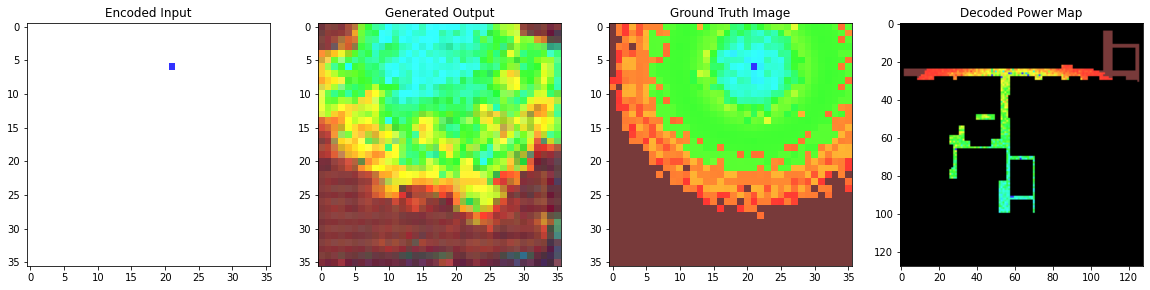

In [36]:
(decoded_output, decoded_output_physical) = label_output_power(22.8,-8.5)

In [29]:
(decoded_output, decoded_output_physical) = label_output_power(-20,-90)

Out of range, base_map is shown
Out of range
out of physical range, try again


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


corresponding 128-scale coordinate 12 109
corresponding pixel coordinate 1.0 31.0
Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_-26.5625_22.8125.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


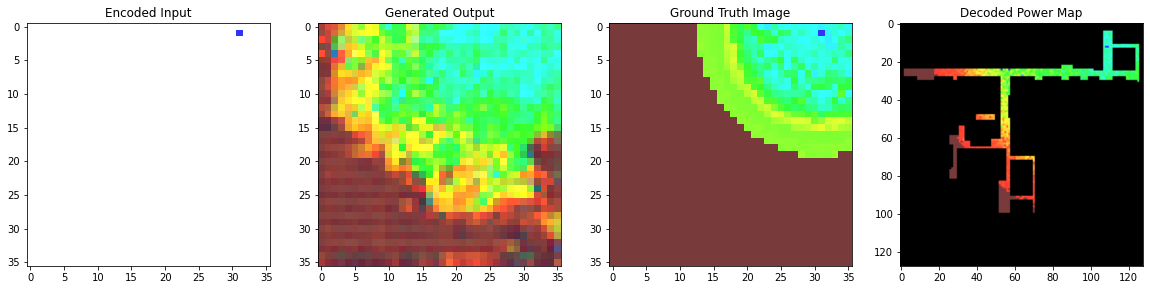

In [30]:
(decoded_output, decoded_output_physical) = label_output_power(-26.56, 22.8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


corresponding 128-scale coordinate 24 100
corresponding pixel coordinate 22.0 28.0
Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_-19.0625_17.1875.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


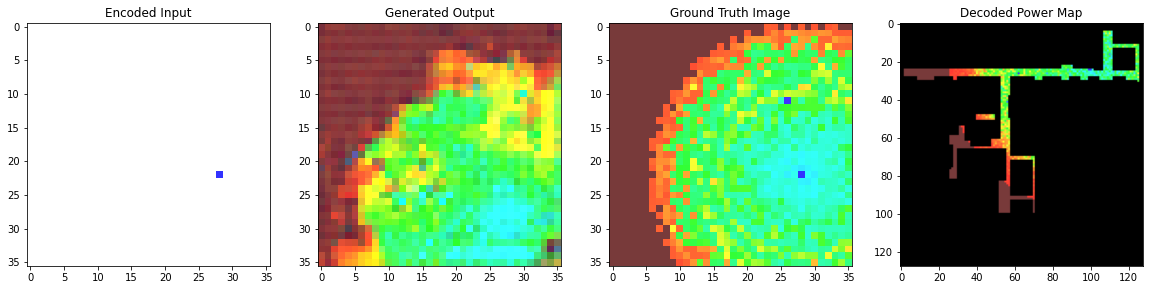

In [31]:
(decoded_output, decoded_output_physical) = label_output_power(-19.211, 17.086)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


corresponding 128-scale coordinate 40 56
corresponding pixel coordinate 12.0 17.0
Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_-9.0625_-10.3125.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


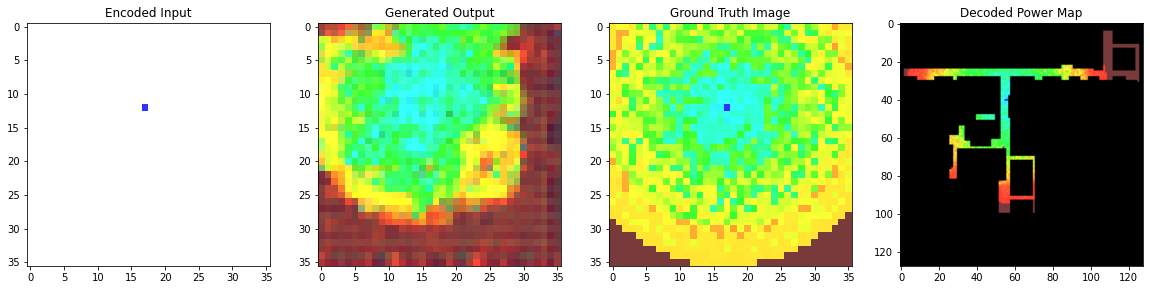

In [32]:
(decoded_output, decoded_output_physical) = label_output_power(-9.01374, -10.344)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


corresponding 128-scale coordinate 27 100
corresponding pixel coordinate 25.0 28.0
Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_-17.1875_17.1875.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


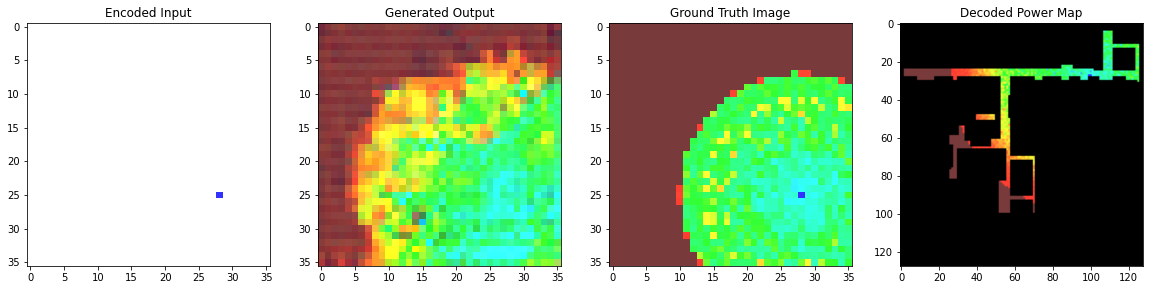

In [33]:
(decoded_output, decoded_output_physical) = label_output_power(-17.2, 17.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


corresponding 128-scale coordinate 65 30
corresponding pixel coordinate 31.0 5.0
Decoded output is saved at /content/drive/MyDrive/ECE496 Capstone/Demo Folder/decoded_output_physical_array_6.5625_-26.5625.csv


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


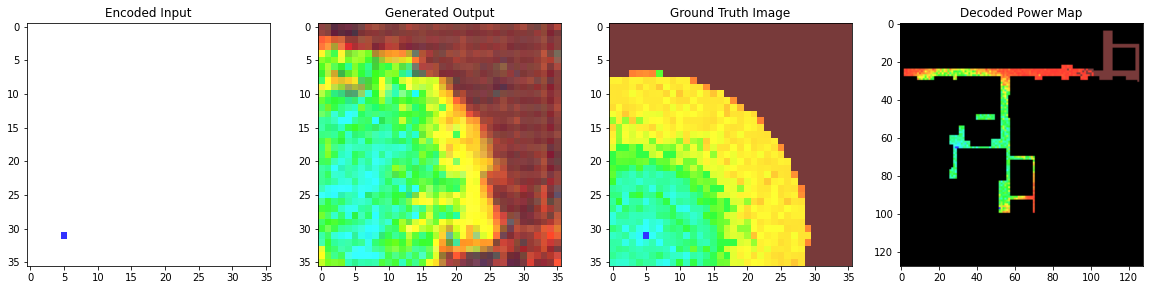

In [34]:
(decoded_output, decoded_output_physical) = label_output_power(6.5, -26.5)